In [1]:
from edgedroid import data as e_data

data, *_ = e_data.load_default_exec_time_data()
data

,run_id,ttf,exec_time,neuroticism
0,134146,0.597441,3.654797,0.375
1,134146,0.553513,4.438645,0.375
2,134146,0.561716,2.943222,0.375
3,134146,0.586512,5.405761,0.375
4,134146,0.558940,5.225161,0.375
...,...,...,...,...
6755,137353,0.557074,6.439071,0.625
6756,137353,0.534339,4.680858,0.625
6757,137353,0.560288,3.467878,0.625
6758,137353,0.579000,2.325759,0.625


In [2]:
test_ttfs = {
    "low": 0,
    "medium": 2,
    "high": 4
}
test_ttfs

{'low': 0, 'medium': 2, 'high': 4}

In [3]:
import pandas as pd
import numpy as np
from edgedroid.models import *
from collections import deque
import itertools as it
from tqdm.notebook import tqdm

warmup_steps = 25
test_steps = 12
reps = 300
rng = np.random.default_rng()

def test_model_constant_ttf(model_name: str, model: ExecutionTimeModel, ttf_tag: str, ttf: float) -> pd.DataFrame:
    rows = deque()
    for rep in range(reps):
        # warmup model
        model.reset()
        for _ in range(warmup_steps):
            model.advance(data["ttf"].sample(1).values[0])

        for i in range(test_steps):
            exec_time = model.advance(ttf).get_execution_time()
            rows.append({
                "model": model_name,
                "ttf_tag": ttf_tag,
                "ttf": ttf,
                "repetition": rep,
                "step": i + 1,
                "exec_time": exec_time,
            })

    return pd.DataFrame(rows)


models = {
    "empirical-low": EmpiricalExecutionTimeModel(neuroticism=0.0),
    "empirical-high": EmpiricalExecutionTimeModel(neuroticism=1.0),
    "theoretical-low": TheoreticalExecutionTimeModel(neuroticism=0.0),
    "theoretical-high": TheoreticalExecutionTimeModel(neuroticism=1.0),
    "rolling-ttf-low": ExpKernelRollingTTFETModel(neuroticism=0.0),
    "rolling-ttf-high": ExpKernelRollingTTFETModel(neuroticism=1.0),
    "fitted-rolling-ttf-low": DistExpKernelRollingTTFETModel(neuroticism=0.0),
    "fitted-rolling-ttf-high": DistExpKernelRollingTTFETModel(neuroticism=1.0)
}

dfs = deque()
combs = list(it.product(models.items(), test_ttfs.items()))
for (name, model), (ttf_tag, ttf) in tqdm(combs, desc="Running models..."):
    dfs.append(test_model_constant_ttf(name, model, ttf_tag, ttf,))

results = pd.concat(dfs, ignore_index=True)
results

Running models...:   0%|          | 0/24 [00:00<?, ?it/s]

,model,ttf_tag,ttf,repetition,step,exec_time
0,empirical-low,low,0,0,1,8.431494
1,empirical-low,low,0,0,2,2.854931
2,empirical-low,low,0,0,3,2.442282
3,empirical-low,low,0,0,4,7.310270
4,empirical-low,low,0,0,5,5.226202
...,...,...,...,...,...,...
86395,fitted-rolling-ttf-high,high,4,299,8,2.050130
86396,fitted-rolling-ttf-high,high,4,299,9,12.161449
86397,fitted-rolling-ttf-high,high,4,299,10,2.998299
86398,fitted-rolling-ttf-high,high,4,299,11,17.507001


In [4]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("Dark2")

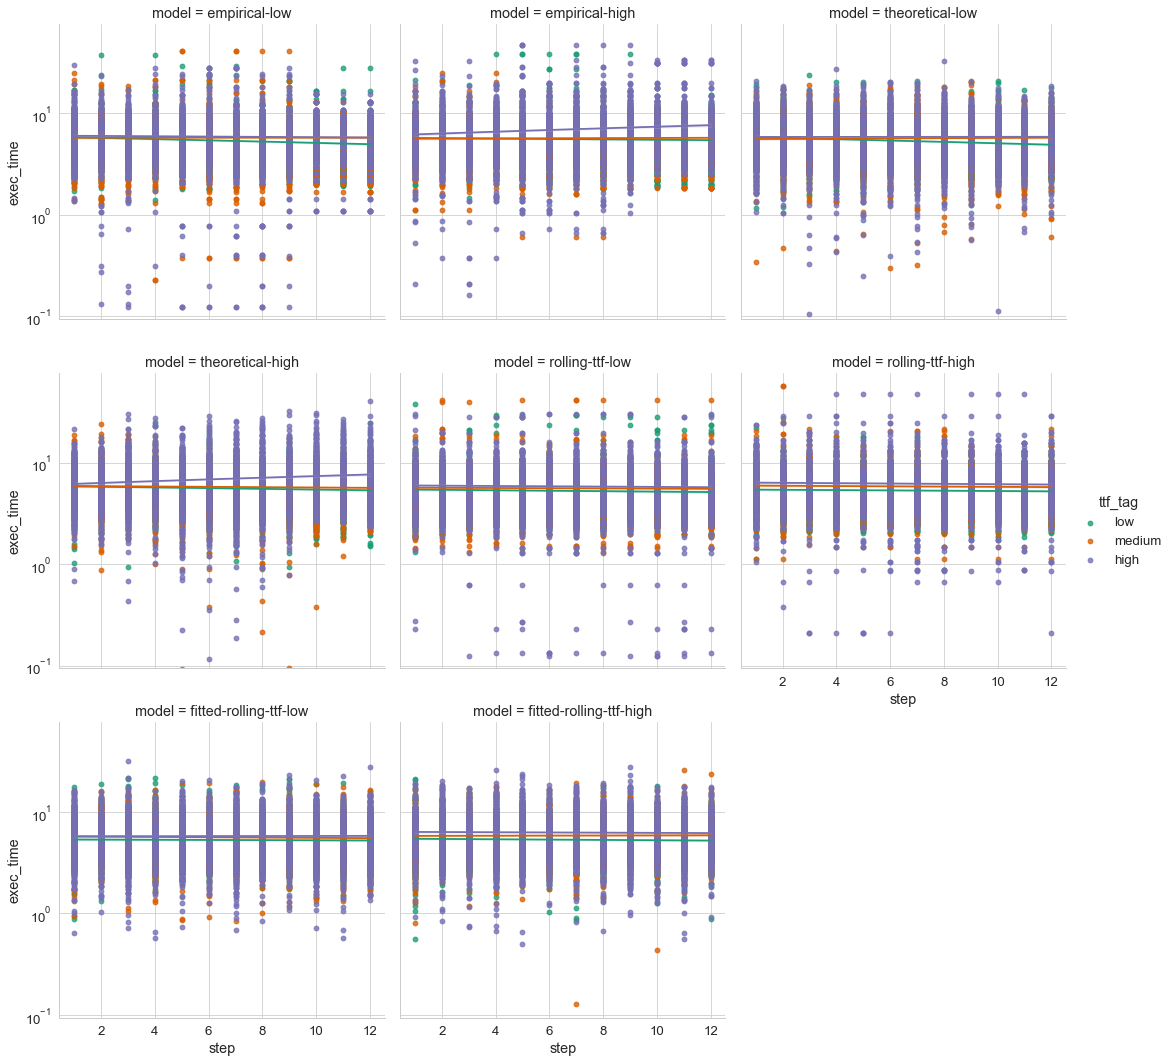

In [5]:
fg = sns.lmplot(
    data=results,
    x="step",
    y="exec_time",
    hue="ttf_tag",
    col="model",
    col_wrap=3,
    fit_reg=True,
    # aspect=3,
)
fg.set(yscale="log")
plt.show()

In [6]:
rolling_results = results[results["model"].str.contains("rolling-ttf")]
(
    rolling_results
    .groupby(["model", "ttf_tag", "step"])
    ["exec_time"]
    .describe()
    .loc[pd.IndexSlice[:, :, [1, 12]]]
)

count      mean       std       min  \
model                   ttf_tag step                                        
fitted-rolling-ttf-high high    1     300.0  6.205424  2.819246  0.000000   
                                12    300.0  6.038406  2.811720  0.908689   
                        low     1     300.0  5.692484  2.962630  0.555935   
                                12    300.0  5.222402  2.263603  0.874680   
                        medium  1     300.0  5.692493  2.602548  0.793962   
                                12    300.0  5.924810  2.524625  2.190740   
fitted-rolling-ttf-low  high    1     300.0  5.546256  2.685163  0.633367   
                                12    300.0  5.663526  2.854292  1.349904   
                        low     1     300.0  5.346238  2.472503  0.879694   
                                12    300.0  5.193090  2.666047  1.749283   
                        medium  1     300.0  5.729866  2.564979  0.932309   
                                12    300.0  5.743016  2.574771  1.493672   
rolling-ttf-high        high    1     300.0  6.213267  3.152815  1.052093   
                                12    300.0  6.187259  3.457068  0.208198   
                        low     1     300.0  5.810954  2.709238  1.120592   
                                12    300.0  5.335232  2.310006  1.999147   
                        medium  1     300.0  5.921454  2.728358  1.120592   
                                12    300.0  5.916751  2.572118  1.120592   
rolling-ttf-low         high    1     300.0  5.944643  3.455126  0.226937   
                                12    300.0  5.845465  3.171924  0.133624   
                        low     1     300.0  5.606103  3.116090  1.303871   
                                12    300.0  5.426323  3.310998  1.953400   
                        medium  1     300.0  5.374503  2.256596  1.396396   
                                12    300.0  5.432264  3.096204  1.438176   

                                           25%       50%       75%        max  
model                   ttf_tag step                                           
fitted-rolling-ttf-high high    1     4.235255  5.700254  7.566547  19.111245  
                                12    4.022678  5.480571  7.182686  17.398400  
                        low     1     3.761901  5.109221  6.789574  21.155487  
                                12    3.612420  4.610554  6.464037  14.529167  
                        medium  1     3.987257  5.208073  6.991930  17.153667  
                                12    4.349490  5.352242  7.046850  23.741357  
fitted-rolling-ttf-low  high    1     3.794601  4.999662  6.590268  16.537294  
                                12    3.797695  5.082275  6.923198  27.638934  
                        low     1     3.837410  4.841401  6.330399  17.463219  
                                12    3.345238  4.375841  6.426765  15.873129  
                        medium  1     3.956875  5.330012  6.901748  15.760059  
                                12    3.990514  5.259308  7.025666  16.448343  
rolling-ttf-high        high    1     4.196024  5.680195  7.564614  23.369813  
                                12    4.105598  5.495824  7.027528  28.775354  
                        low     1     3.874281  5.227600  7.259210  21.727171  
                                12    3.621382  4.905551  6.519831  15.639732  
                        medium  1     4.194834  5.307142  7.009752  20.626838  
                                12    4.221311  5.350492  7.090039  21.248034  
rolling-ttf-low         high    1     3.844435  5.176432  7.115326  30.155684  
                                12    3.887939  5.143782  7.092388  30.155684  
                        low     1     3.636651  5.051431  6.852277  37.976307  
                                12    3.217042  4.712198  6.430460  29.465998  
                        medium  1     3.778893  4.993907  6.665224  18.090997  
                                12 

In [11]:
# check behavior changing ttf after long periods of steady ttfs
reps = 300
def test_transitions(
    model_name: str,
    model: ExecutionTimeModel,
    origin_ttf_tag: str,
    origin_ttf: float,
    destination_ttf_tag: str,
    destination_ttf: float
) -> pd.DataFrame:
    rows = deque()
    for rep in range(reps):
        # warmup model
        model.reset()
        for _ in range(warmup_steps):
            model.advance(origin_ttf)

        # take a single sample in the destination ttf
        exec_time = model.advance(destination_ttf).get_execution_time()
        rows.append({
            "model": model_name,
            "origin_ttf": origin_ttf_tag,
            "destination_ttf": destination_ttf_tag,
            "repetition": rep,
            "exec_time": exec_time,
            "transition": f"{origin_ttf_tag} -> {destination_ttf_tag}"
        })

    return pd.DataFrame(rows)

dfs = deque()
combs = list(it.product(models.items(), test_ttfs.items(), test_ttfs.items()))
for (name, model), (orig_ttf_tag, orig_ttf), (dest_ttf_tag, dest_ttf) in tqdm(combs, desc="Running models..."):
    dfs.append(test_transitions(name, model, orig_ttf_tag, orig_ttf, dest_ttf_tag, dest_ttf))

results = pd.concat(dfs, ignore_index=True)
results

Running models...:   0%|          | 0/72 [00:00<?, ?it/s]

,model,origin_ttf,destination_ttf,repetition,exec_time,transition
0,empirical-low,low,low,0,9.467287,low -> low
1,empirical-low,low,low,1,2.493421,low -> low
2,empirical-low,low,low,2,3.473061,low -> low
3,empirical-low,low,low,3,6.221640,low -> low
4,empirical-low,low,low,4,4.283982,low -> low
...,...,...,...,...,...,...
21595,fitted-rolling-ttf-high,high,high,295,2.121284,high -> high
21596,fitted-rolling-ttf-high,high,high,296,5.205778,high -> high
21597,fitted-rolling-ttf-high,high,high,297,6.261386,high -> high
21598,fitted-rolling-ttf-high,high,high,298,10.758271,high -> high


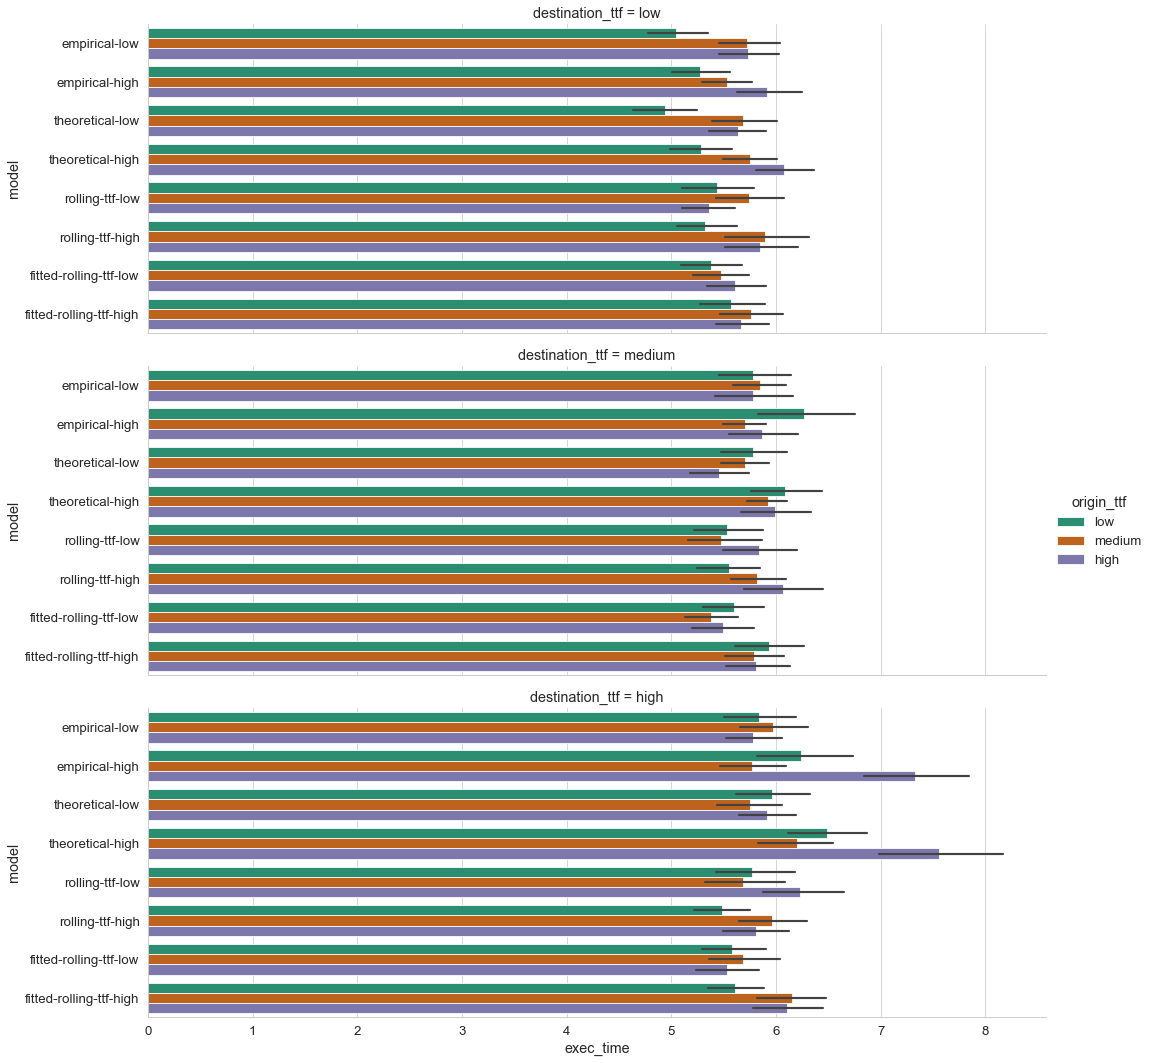

In [12]:
fg = sns.catplot(
    kind="bar",
    # join=False,
    dodge=True,
    data=results,
    hue="origin_ttf",
    row="destination_ttf",
    y="model",
    x="exec_time",
    aspect=3,
)
plt.show()

In [9]:
def test_ttf_to_exec_time(model_name: str, model: ExecutionTimeModel, ttf_tag: str, ttf: float) -> pd.DataFrame:
    rows = deque()
    for rep in range(reps):
        # warmup model
        model.reset()
        for _ in range(warmup_steps):
            model.advance(data["ttf"].sample(1).values[0])

        # advance the model and take a single sample
        exec_time = model.advance(ttf).get_execution_time()
        rows.append({
            "model": model_name,
            "ttf_tag": ttf_tag,
            "ttf": ttf,
            "repetition": rep,
            "exec_time": exec_time,
        })

    return pd.DataFrame(rows)

dfs = deque()
combs = list(it.product(models.items(), test_ttfs.items()))
for (name, model), (ttf_tag, ttf) in tqdm(combs, desc="Running models..."):
    dfs.append(test_ttf_to_exec_time(name, model, ttf_tag, ttf))

results = pd.concat(dfs, ignore_index=True)
results

Running models...:   0%|          | 0/24 [00:00<?, ?it/s]

,model,ttf_tag,ttf,repetition,exec_time
0,empirical-low,low,0,0,3.309985
1,empirical-low,low,0,1,3.420180
2,empirical-low,low,0,2,9.037329
3,empirical-low,low,0,3,4.467639
4,empirical-low,low,0,4,2.943222
...,...,...,...,...,...
7195,fitted-rolling-ttf-high,high,4,295,2.511514
7196,fitted-rolling-ttf-high,high,4,296,6.167490
7197,fitted-rolling-ttf-high,high,4,297,2.551387
7198,fitted-rolling-ttf-high,high,4,298,7.493505


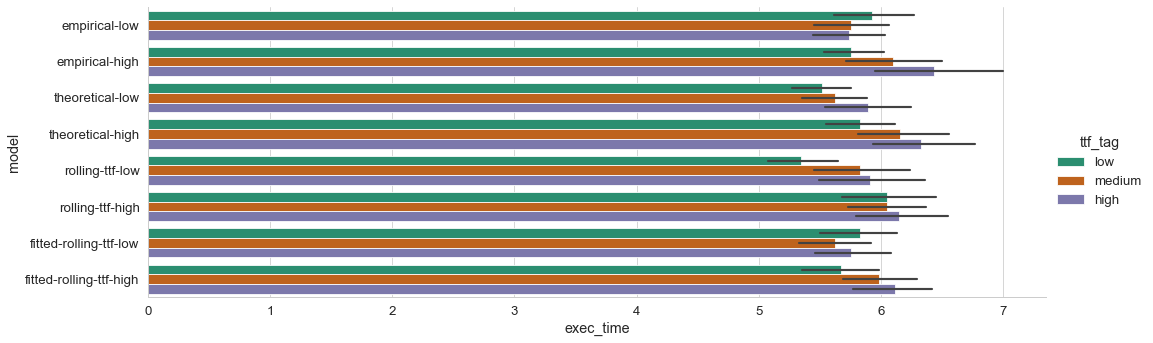

In [10]:
fg = sns.catplot(
    kind="bar",
    # join=False,
    dodge=True,
    data=results,
    y="model",
    x="exec_time",
    hue="ttf_tag",
    aspect=3,
)
plt.show()